# Install & Import Dependencies

In [72]:
!pip install jcopml -q
!pip install demoji -q
!pip install swifter -q
!pip install Sastrawi -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import re
import demoji
from nltk.corpus import stopwords
import swifter
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from collections import Counter
from collections import defaultdict
from jcopml.plot import plot_missing_value, plot_correlation_matrix, plot_association_matrix

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [34]:
# url = 'hf://datasets/shobrunjb/skincare-product-review-indo-v2/pre-processing.csv'
url = 'https://raw.githubusercontent.com/Fake-Sentiment-Review-Detection-Spiill/spiill-data-and-utils/refs/heads/main/final%20dataset%206000-v2.csv'
df_reviews = pd.read_csv(url)
df_reviews.tail(3)

username  rate        date label sentimen  \
5997  eiswahyudi     3  2024-03-17   non  neutral   
5998     dkusumo     5  2023-09-18   non  neutral   
5999      adisti     3  2023-09-11   non  neutral   

                                                reviews            produk  
5997  Pasar saham Indonesia menunjukkan tren yang st...  Masker Skintific  
5998  Penggunaan kendaraan listrik mulai diminati di...  Masker Skintific  
5999                Lumayan lancar dengan berjalan baik  Masker Skintific

# EDA + Preprocessing

In [35]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0    username  6000 non-null   object
 1   rate       6000 non-null   int64 
 2   date       6000 non-null   object
 3   label      6000 non-null   object
 4   sentimen   6000 non-null   object
 5   reviews    6000 non-null   object
 6   produk     6000 non-null   object
dtypes: int64(1), object(6)
memory usage: 328.2+ KB


In [36]:
df_reviews.nunique()

 username    5499
rate            5
date         5255
label           3
sentimen        3
reviews      5950
produk        238
dtype: int64

## Missing Value

missing_value    %
 username              0  0.0
rate                   0  0.0
date                   0  0.0
label                  0  0.0
sentimen               0  0.0
reviews                0  0.0
produk                 0  0.0

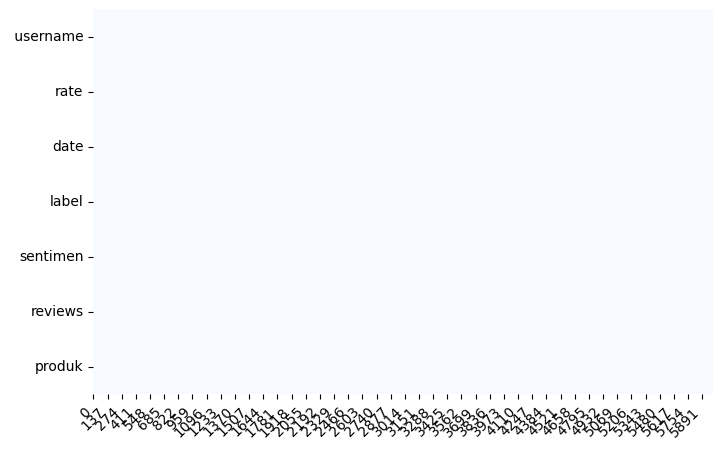

In [37]:
plot_missing_value(df_reviews, return_df=True, figsize=(8, 5))

## Descriptive

In [38]:
df_reviews.describe(exclude=['object']).T

count   mean       std  min  25%  50%  75%  max
rate  6000.0  3.798  1.169512  1.0  3.0  4.0  5.0  5.0

In [39]:
df_reviews.describe(include=['object']).T

count unique                                                top  \
 username  6000   5499                                         cici selvi   
date       6000   5255                                   2024-05-23 12:07   
label      6000      3                                            trusted   
sentimen   6000      3                                           positive   
reviews    6000   5950  Investasi di sektor teknologi terus menunjukka...   
produk     6000    238                                  Acnes Creamy Wash   

           freq  
 username    11  
date          6  
label      3924  
sentimen   3725  
reviews       4  
produk      929

## Duplicate

In [40]:
df_reviews.duplicated().sum()

0

In [41]:
df_reviews.reviews.duplicated().sum()

50

In [42]:
df_reviews[df_reviews.reviews.duplicated(keep=False)]

username  rate              date    label  sentimen  \
73             awrel     1   15-09-2021 8:49  trusted  negative   
74     zefanyamonica     1   14-09-2021 5:59  trusted  negative   
610        Adiansyah     4  08-09-2021 18:18  trusted  positive   
612        missriviu     5  11-08-2021 17:09  trusted  positive   
683     Gemma_evrard     4   29-10-2022 9:11  trusted  positive   
...              ...   ...               ...      ...       ...   
5991  estionosusanti     2        2024-08-10      non   neutral   
5992       bharyanto     3        2024-04-25      non   neutral   
5993      utamanarji     3        2024-08-21      non   neutral   
5994     faridakania     2        2024-07-30      non   neutral   
5996      oktawasita     2        2023-08-27      non   neutral   

                                                reviews             produk  
73    Dulu pernah cobain produk ini, aku apply pagi ...       Acnes Powder  
74    Dulu pernah cobain produk ini, aku apply pagi ...       Acnes Powder  
610   lembut di muka, busanya juga pas dan nggak bik...  Acnes Creamy Wash  
612   lembut di muka, busanya juga pas dan nggak bik...  Acnes Creamy Wash  
683   untuk mukaku yg normal2 aja aku ngerasa fw ini...  Acnes Creamy Wash  
...                                                 ...                ...  
5991  Pemerintah gencar mendorong program vaksinasi ...   Masker Skintific  
5992  Olahraga pagi mulai menjadi rutinitas banyak o...   Masker Skintific  
5993  Investasi di sektor teknologi terus menunjukka...   Masker Skintific  
5994  Peran UMKM dalam perekonomian nasional semakin...   Masker Skintific  
5996  Peran UMKM dalam perekonomian nasional semakin...   Masker Skintific  

[93 rows x 7 columns]

In [43]:
df_reviews.iloc[683]['reviews']

'untuk mukaku yg normal2 aja aku ngerasa fw ini gada efek sama sekali ya. tapi adekku yg berjerawat juga pakai ini, setelah 6 bulan pemakaian paket acnes lengkap, bener2 jerawatnya berkurang sih. sabunnya juga enak gada bau2 yg nyengat di idung. natural aja gitu.'

In [44]:
df_reviews[df_reviews.reviews == df_reviews.iloc[683]['reviews']]['reviews']

683    untuk mukaku yg normal2 aja aku ngerasa fw ini...
684    untuk mukaku yg normal2 aja aku ngerasa fw ini...
Name: reviews, dtype: object

In [45]:
print(df_reviews.shape)
df_reviews = df_reviews.drop_duplicates(subset=['reviews'], keep='first', inplace=False)
print(df_reviews.duplicated(subset=['reviews']).sum())
print(df_reviews.shape)

(6000, 7)
0
(5950, 7)


In [46]:
df_reviews

username  rate                 date    label  sentimen  \
0        mtraandita     3  19-05-2024 01:36 PM  trusted   neutral   
1     Miftahuljahra     2  18-05-2024 06:38 AM  trusted  negative   
2     Marizka_nuril     3  18-05-2024 06:06 AM  trusted   neutral   
3            Denyul     3  17-05-2024 10:28 AM  trusted   neutral   
4      anakusumaayu     3  16-05-2024 02:59 AM  trusted   neutral   
...             ...   ...                  ...      ...       ...   
5994    faridakania     2           2024-07-30      non   neutral   
5995   hasanwahyuni     1           2023-09-11      non   neutral   
5997     eiswahyudi     3           2024-03-17      non   neutral   
5998        dkusumo     5           2023-09-18      non   neutral   
5999         adisti     3           2023-09-11      non   neutral   

                                                reviews            produk  
0     Waktu smp aku pakai ss ini selama ±2 tahun, te...   Emina Sunscreen  
1     Aku ga terlalu cocok pake produk ini terlebih ...   Emina Sunscreen  
2     Sunscreen pertama aku sewaktu kenal skincare, ...   Emina Sunscreen  
3     Teksturnya agak watery gitu\nDiblendnya agak l...   Emina Sunscreen  
4     ini adalah suncreen pertamaku , dulu cocok ban...   Emina Sunscreen  
...                                                 ...               ...  
5994  Peran UMKM dalam perekonomian nasional semakin...  Masker Skintific  
5995  Penggunaan teknologi di Indonesia semakin berk...  Masker Skintific  
5997  Pasar saham Indonesia menunjukkan tren yang st...  Masker Skintific  
5998  Penggunaan kendaraan listrik mulai diminati di...  Masker Skintific  
5999                Lumayan lancar dengan berjalan baik  Masker Skintific  

[5950 rows x 7 columns]

# Feature Engineering

In [47]:
df_reviews['reviews'].iloc[0]

"Waktu smp aku pakai ss ini selama ±2 tahun, terus aku stop selama covid karena ga pernah keluar. Pas coba pake lagi, tiba2 breakout parah banget sehari setelahnya, padahal exp product masih lama. Dari aman selama dua tahun, terus tiba-tiba ga cocok dan breakout parah yg jerawatan batu gitu. I don't know why, sepertinya kulitku jadi sensitif dengan fragrancenya. Tapi untuk yg kulit normal, ini oke oke aja kayanya. "

## Remove Link, Hashtag, Mention

In [48]:
def cleanUpTweet(txt):
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt) #Remove mentions
    txt = re.sub(r'#[A-Za-z0-9_]+', '', txt) #Remove hashtags
    txt = re.sub(r'RT ', '', txt) #Remove retweets
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt) #Remove urls
    return txt

def remove_emojis(text):
    txt = demoji.replace(text, '')
    return txt

df_reviews['no_link_hashtag_reviews'] = df_reviews['reviews'].apply(cleanUpTweet)
df_reviews['no_emojis_reviews'] = df_reviews['no_link_hashtag_reviews'].apply(remove_emojis)

df_reviews['no_emojis_reviews'].iloc[0]

"Waktu smp aku pakai ss ini selama ±2 tahun, terus aku stop selama covid karena ga pernah keluar. Pas coba pake lagi, tiba2 breakout parah banget sehari setelahnya, padahal exp product masih lama. Dari aman selama dua tahun, terus tiba-tiba ga cocok dan breakout parah yg jerawatan batu gitu. I don't know why, sepertinya kulitku jadi sensitif dengan fragrancenya. Tapi untuk yg kulit normal, ini oke oke aja kayanya. "

## Remove HTML Char

In [49]:
def removeHTMLChar(text):
    text = ' '.join(re.sub("([&][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    return text

df_reviews['no_html_reviews'] = df_reviews['no_emojis_reviews'].apply(removeHTMLChar)

df_reviews['no_html_reviews'].iloc[0]

"Waktu smp aku pakai ss ini selama ±2 tahun, terus aku stop selama covid karena ga pernah keluar. Pas coba pake lagi, tiba2 breakout parah banget sehari setelahnya, padahal exp product masih lama. Dari aman selama dua tahun, terus tiba-tiba ga cocok dan breakout parah yg jerawatan batu gitu. I don't know why, sepertinya kulitku jadi sensitif dengan fragrancenya. Tapi untuk yg kulit normal, ini oke oke aja kayanya."

## Remove All Special Character

In [50]:
def remove_text_special(text):
    text = text.replace('\t', " ").replace('\n', " ").replace(r'\u', " ").replace("\\", "")
    text = text.encode('ascii', 'replace').decode('ascii')
    text = ' '.join(re.sub(r"([@#&][A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text).split())
    return text.replace("http://", " ").replace("https://", " ")

df_reviews['no_special_char_reviews'] = df_reviews['no_html_reviews'].apply(remove_text_special)

df_reviews['no_special_char_reviews'].iloc[0]

"Waktu smp aku pakai ss ini selama ?2 tahun, terus aku stop selama covid karena ga pernah keluar. Pas coba pake lagi, tiba2 breakout parah banget sehari setelahnya, padahal exp product masih lama. Dari aman selama dua tahun, terus tiba-tiba ga cocok dan breakout parah yg jerawatan batu gitu. I don't know why, sepertinya kulitku jadi sensitif dengan fragrancenya. Tapi untuk yg kulit normal, ini oke oke aja kayanya."

## Remove Number

In [51]:
def removeNumbers(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text

df_reviews['no_number_reviews'] = df_reviews['no_special_char_reviews'].apply(removeNumbers)

df_reviews['no_number_reviews'].iloc[0]

"Waktu smp aku pakai ss ini selama ? tahun, terus aku stop selama covid karena ga pernah keluar. Pas coba pake lagi, tiba breakout parah banget sehari setelahnya, padahal exp product masih lama. Dari aman selama dua tahun, terus tiba-tiba ga cocok dan breakout parah yg jerawatan batu gitu. I don't know why, sepertinya kulitku jadi sensitif dengan fragrancenya. Tapi untuk yg kulit normal, ini oke oke aja kayanya."

## Remove Punctuation

In [52]:
def remove_punctuation(txt):
  txt = re.sub(r'[^\w\s]', ' ', txt)
  return txt

df_reviews['no_punct_reviews'] = df_reviews['no_number_reviews'].apply(remove_punctuation)

df_reviews['no_punct_reviews'].iloc[0]

'Waktu smp aku pakai ss ini selama   tahun  terus aku stop selama covid karena ga pernah keluar  Pas coba pake lagi  tiba breakout parah banget sehari setelahnya  padahal exp product masih lama  Dari aman selama dua tahun  terus tiba tiba ga cocok dan breakout parah yg jerawatan batu gitu  I don t know why  sepertinya kulitku jadi sensitif dengan fragrancenya  Tapi untuk yg kulit normal  ini oke oke aja kayanya '

## Remove Whitespace

In [53]:
def remove_whitespace_LT(text):
    return text.strip()

def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

def spell(word):
    if re.search(r'([a-zA-Z])\1{2,}', word):
        rword = re.sub(r'([a-zA-Z])\1{2,}','\1', word)
        return rword
    else:
        return word

df_reviews['no_whitespace_reviews_reviews'] = df_reviews['no_punct_reviews'].apply(remove_whitespace_LT)
df_reviews['no_whitespace_reviews_reviews'] = df_reviews['no_whitespace_reviews_reviews'].apply(remove_whitespace_multiple)
df_reviews['no_whitespace_reviews_reviews'] = df_reviews['no_whitespace_reviews_reviews'].apply(spell)

df_reviews['no_whitespace_reviews_reviews'].iloc[0]

'Waktu smp aku pakai ss ini selama tahun terus aku stop selama covid karena ga pernah keluar Pas coba pake lagi tiba breakout parah banget sehari setelahnya padahal exp product masih lama Dari aman selama dua tahun terus tiba tiba ga cocok dan breakout parah yg jerawatan batu gitu I don t know why sepertinya kulitku jadi sensitif dengan fragrancenya Tapi untuk yg kulit normal ini oke oke aja kayanya'

## To Lowercase

In [54]:
df_reviews['lowercase_reviews'] = df_reviews['no_whitespace_reviews_reviews'].apply(lambda item: str(item).lower())

df_reviews['lowercase_reviews'].iloc[0]

'waktu smp aku pakai ss ini selama tahun terus aku stop selama covid karena ga pernah keluar pas coba pake lagi tiba breakout parah banget sehari setelahnya padahal exp product masih lama dari aman selama dua tahun terus tiba tiba ga cocok dan breakout parah yg jerawatan batu gitu i don t know why sepertinya kulitku jadi sensitif dengan fragrancenya tapi untuk yg kulit normal ini oke oke aja kayanya'

## Tokenize

In [55]:
def word_tokenize_wrapper(text):
    return word_tokenize(text)
    
def tokenize(word):
  word = word.split(" ")
  return word

df_reviews['tokens_reviews'] = df_reviews['lowercase_reviews'].apply(word_tokenize_wrapper)

df_reviews['tokens_reviews'].iloc[0]

['waktu',
 'smp',
 'aku',
 'pakai',
 'ss',
 'ini',
 'selama',
 'tahun',
 'terus',
 'aku',
 'stop',
 'selama',
 'covid',
 'karena',
 'ga',
 'pernah',
 'keluar',
 'pas',
 'coba',
 'pake',
 'lagi',
 'tiba',
 'breakout',
 'parah',
 'banget',
 'sehari',
 'setelahnya',
 'padahal',
 'exp',
 'product',
 'masih',
 'lama',
 'dari',
 'aman',
 'selama',
 'dua',
 'tahun',
 'terus',
 'tiba',
 'tiba',
 'ga',
 'cocok',
 'dan',
 'breakout',
 'parah',
 'yg',
 'jerawatan',
 'batu',
 'gitu',
 'i',
 'don',
 't',
 'know',
 'why',
 'sepertinya',
 'kulitku',
 'jadi',
 'sensitif',
 'dengan',
 'fragrancenya',
 'tapi',
 'untuk',
 'yg',
 'kulit',
 'normal',
 'ini',
 'oke',
 'oke',
 'aja',
 'kayanya']

In [56]:
word_count = defaultdict(int)
for tokens in df_reviews['tokens_reviews']:
    for token in tokens:
       word_count[token] += 1

word_count_df = pd.DataFrame({"key": word_count.keys(), "count": word_count.values()})
word_count_df_sort = word_count_df.sort_values('count', axis=0, ascending=False, inplace=False)
word_count_df_sort.head(20)

key  count
34      dan   4596
5       ini   4551
2       aku   3735
71       di   2989
22   banget   2804
68     yang   2673
50     tapi   2139
12       ga   2013
144    juga   1889
52    kulit   1808
46     jadi   1740
17     pake   1694
51    untuk   1637
75    bikin   1573
35       yg   1511
157    buat   1498
89      nya   1394
33    cocok   1329
198     sih   1317
252   bagus   1250

## Stopword Removal

In [64]:
list_stopwords = stopwords.words('indonesian')
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       'yah', # extend stopword 
                      ]) # dominant word

stopword_url = 'https://raw.githubusercontent.com/Fake-Sentiment-Review-Detection-Spiill/spiill-data-and-utils/refs/heads/main/stopwords.txt'

txt_stopword = pd.read_csv(stopword_url, names= ["stopwords"], header = None)
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))
list_stopwords = set(list_stopwords)
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]
    
df_reviews['no_stopwords_reviews'] = df_reviews['tokens_reviews'].apply(stopwords_removal) 

df_reviews['no_stopwords_reviews'].iloc[0]

['smp',
 'pakai',
 'stop',
 'covid',
 'pas',
 'coba',
 'pake',
 'breakout',
 'parah',
 'banget',
 'sehari',
 'setelahnya',
 'exp',
 'product',
 'aman',
 'cocok',
 'breakout',
 'parah',
 'jerawatan',
 'batu',
 'know',
 'kulitku',
 'sensitif',
 'fragrancenya',
 'kulit',
 'normal',
 'oke',
 'oke',
 'kayanya']

In [66]:
word_count = defaultdict(int)
for tokens in df_reviews['no_stopwords_reviews']:
    for token in tokens:
       word_count[token] += 1

word_count_df = pd.DataFrame({"key": word_count.keys(), "count": word_count.values()})
word_count_df_sort = word_count_df.sort_values('count', axis=0, ascending=False, inplace=False)
word_count_df_sort.head(20)

key  count
9      banget   2804
22      kulit   1808
6        pake   1694
15      cocok   1329
150     bagus   1250
26     produk   1243
40       suka   1135
370    kering    974
4         pas    968
134      beli    887
1       pakai    866
436    rambut    849
59    lumayan    737
27       muka    670
420  wanginya    605
323     bibir    602
34    jerawat    568
330  warnanya    549
108     wajah    540
384     warna    502

## Stemming

In [70]:
df_normalized = pd.DataFrame(df_reviews['reviews'])
df_normalized['cleaned_reviews'] = df_reviews['lowercase_reviews']
df_normalized['tokens_reviews'] = df_reviews['tokens_reviews']
df_normalized['no_stopwords_tokens_reviews'] = df_reviews['no_stopwords_reviews']

normalizad_word = df_normalized

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1]  

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

df_reviews['normalized_reviews'] = df_reviews['no_stopwords_reviews'].apply(normalized_term)

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df_reviews['normalized_reviews']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

df_reviews['stemmed_reviews'] = df_reviews['normalized_reviews'].swifter.apply(get_stemmed_term)

<ipython-input-70-6b91f6d1d440>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[0] not in normalizad_word_dict:
<ipython-input-70-6b91f6d1d440>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalizad_word_dict[row[0]] = row[1]


10389
------------------------
smp : smp
pakai : pakai
stop : stop
covid : covid
pas : pas
coba : coba
pake : pake
breakout : breakout
parah : parah
banget : banget
sehari : hari
setelahnya : telah
exp : exp
product : product
aman : aman
cocok : cocok
jerawatan : jerawat
batu : batu
know : know
kulitku : kulit
sensitif : sensitif
fragrancenya : fragrancenya
kulit : kulit
normal : normal
oke : oke
kayanya : kaya
produk : produk
muka : muka
oily : oily
skin : skin
dipake : dipake
langsungkeluar : langsungkeluar
jerawatnya : jerawat
dryskin : dryskin
jerawat : jerawat
sunscreen : sunscreen
kenal : kenal
skincare : skincare
first : first
apply : apply
suka : suka
fragrance : fragrance
kencang : kencang
teksturnya : tekstur
gel : gel
gampang : gampang
repurchase : repurchase
karna : karna
harganya : harga
affordable : affordable
sekolah : sekolah
hasil : hasil
pemakaian : pakai
kyk : kyk
ngerasa : ngerasa
keringettan : keringettan
huhu : huhu
watery : watery
diblendnya : diblendnya
lumayan 

AttributeError: 'Series' object has no attribute 'swifter'

# Second EDA (Checking data after processing)

In [76]:
df_reviews.tail(3)

username  rate        date label sentimen  \
5997  eiswahyudi     3  2024-03-17   non  neutral   
5998     dkusumo     5  2023-09-18   non  neutral   
5999      adisti     3  2023-09-11   non  neutral   

                                                reviews            produk  \
5997  Pasar saham Indonesia menunjukkan tren yang st...  Masker Skintific   
5998  Penggunaan kendaraan listrik mulai diminati di...  Masker Skintific   
5999                Lumayan lancar dengan berjalan baik  Masker Skintific   

                                no_link_hashtag_reviews  \
5997  Pasar saham Indonesia menunjukkan tren yang st...   
5998  Penggunaan kendaraan listrik mulai diminati di...   
5999                Lumayan lancar dengan berjalan baik   

                                      no_emojis_reviews  \
5997  Pasar saham Indonesia menunjukkan tren yang st...   
5998  Penggunaan kendaraan listrik mulai diminati di...   
5999                Lumayan lancar dengan berjalan baik   

                                        no_html_reviews  \
5997  Pasar saham Indonesia menunjukkan tren yang st...   
5998  Penggunaan kendaraan listrik mulai diminati di...   
5999                Lumayan lancar dengan berjalan baik   

                                no_special_char_reviews  \
5997  Pasar saham Indonesia menunjukkan tren yang st...   
5998  Penggunaan kendaraan listrik mulai diminati di...   
5999                Lumayan lancar dengan berjalan baik   

                                      no_number_reviews  \
5997  Pasar saham Indonesia menunjukkan tren yang st...   
5998  Penggunaan kendaraan listrik mulai diminati di...   
5999                Lumayan lancar dengan berjalan baik   

                                       no_punct_reviews  \
5997  Pasar saham Indonesia menunjukkan tren yang st...   
5998  Penggunaan kendaraan listrik mulai diminati di...   
5999                Lumayan lancar dengan berjalan baik   

                          no_whitespace_reviews_reviews  \
5997  Pasar saham Indonesia menunjukkan tren yang st...   
5998  Penggunaan kendaraan listrik mulai diminati di...   
5999                Lumayan lancar dengan berjalan baik   

                                      lowercase_reviews  \
5997  pasar saham indonesia menunjukkan tren yang st...   
5998  penggunaan kendaraan listrik mulai diminati di...   
5999                lumayan lancar dengan berjalan baik   

                                         tokens_reviews  \
5997  [pasar, saham, indonesia, menunjukkan, tren, y...   
5998  [penggunaan, kendaraan, listrik, mulai, dimina...   
5999          [lumayan, lancar, dengan, berjalan, baik]   

                                   no_stopwords_reviews  \
5997            [pasar, saham, indonesia, tren, stabil]   
5998  [penggunaan, kendaraan, listrik, diminati, per...   
5999                        [lumayan, lancar, berjalan]   

                                     normalized_reviews  \
5997            [pasar, saham, indonesia, tren, stabil]   
5998  [penggunaan, kendaraan, listrik, diminati, per...   
5999                        [lumayan, lancar, berjalan]   

                              stemmed_reviews  
5997  [pasar, saham, indonesia, tren, stabil]  
5998     [guna, kendara, listrik, mati, kota]  
5999                 [lumayan, lancar, jalan]

## Duplicate

In [87]:
print(f'lowercase_reviews (cleaned)\t: {df_reviews.normalized_reviews.duplicated().sum()}')
print(f'tokens_reviews (cleaned)\t: {df_reviews.tokens_reviews.duplicated().sum()}')
print(f'normalized_reviews (cleaned)\t: {df_reviews.normalized_reviews.duplicated().sum()}')
print(f'stemmed_reviews (cleaned)\t: {df_reviews.stemmed_reviews.duplicated().sum()}')

lowercase_reviews (cleaned)	: 28
tokens_reviews (cleaned)	: 14
normalized_reviews (cleaned)	: 28
stemmed_reviews (cleaned)	: 31


In [89]:
df_reviews[df_reviews.stemmed_reviews.duplicated(keep=False)]

username  rate                      date    label  sentimen  \
951             mayuhan01     5          2024-05-23 12:31     fake  positive   
953        agismaulana000     5          2024-05-23 11:12     fake  positive   
956        maharaniariana     5          2024-05-23 11:53     fake  positive   
961     mhayarahyapennyak     5          2024-05-23 12:07     fake  positive   
1086           rosidaf_12     5          2024-05-23 10:54     fake  positive   
1112        lisaamalia123     5           2024-05-23 9:34      non  positive   
1168           g_lbcllpyw     4          2024-05-22 21:40     fake  positive   
1198              h*****m     5          2024-05-22 21:08      non  positive   
1215        fahrulfananie     5          2024-05-22 14:36     fake  positive   
1217         arisstiawan.     5          2024-05-22 14:16     fake  positive   
1239      faisalrahman124     5          2024-05-21 17:14     fake  positive   
1259              w*****l     5           2024-05-21 0:40      non  negative   
1266            oppando88     5          2024-05-20 17:29     fake  positive   
1312          051lilisrna     5          2024-05-21 21:04     fake  positive   
1335      asmiasmiasminde     5           2024-05-20 8:01      non  positive   
1343           psaputra22     5          2024-05-19 14:11     fake  positive   
1368             182subur     5           2024-05-18 1:10      non  positive   
1457    WindaPrameswari03     2           01-11-2017 7:26      non  negative   
1458       AyuRahmawati86     2          31-10-2017 21:41      non  negative   
1496    LinaPuspitasari41     2          31-05-2017 14:15      non  negative   
1497       NiaNurhayati57     2           30-05-2017 6:48      non  negative   
1981           Krismawati     3           07-07-2021 7:23     fake   neutral   
2028           yuniarrr23     1       04-05-2024 12:54 PM     fake  negative   
2036      finkasalsabilla     1           24-01-2024 7:42     fake  negative   
2097          chitanggini     3           27-08-2023 4:08     fake   neutral   
2100            adindapkz     3           04-08-2023 9:22     fake   neutral   
2202              d*****s     3          2024-05-23 12:19      non   neutral   
2210              e*****i     3          2024-05-23 10:53      non   neutral   
2212     virginiamerentek     3          2024-05-23 12:26      non   neutral   
2213     virginiamerentek     3          2024-05-23 12:26      non   neutral   
2215              y*****i     3          2024-05-23 11:07      non   neutral   
2219              a*****8     3          2024-05-23 12:41      non   neutral   
2220         milla.khusna     3          2024-05-23 10:58      non  negative   
2223           naswaa0010     3          2024-05-23 11:44      non  negative   
2235              a*****a     3          2024-05-23 11:26      non   neutral   
2245             dyahzafa     3          2024-05-23 12:34      non   neutral   
2551         Nina Hartono     3          19-12-2017 13:57      non   neutral   
2626        Vina Bachtiar     3           23-01-2017 6:40      non   neutral   
3211      kendra valentin     4  2020-05-23T05:37:35.668Z     fake  positive   
3363      Shanty Iskandar     4  2018-08-24T19:35:46.000Z  trusted  positive   
3415        Aisyah Amalia     3  2018-08-08T15:45:08.000Z  trusted   neutral   
3706  Dewi FaradillaSetia     5  2021-03-17T00:05:33.699Z  trusted  positive   
3715       Aprilia Sejati     4  2021-01-15T03:32:02.783Z  trusted  positive   
4011         Mhanvan Java     5  2022-03-12T13:34:16.868Z      non  positive   
4012        Pensyl Vaniah     5  2022-03-04T14:10:51.540Z      non  positive   
4013    marlina gavaputri     5  2022-03-01T07:29:42.767Z      non  positive   
4029       kezia Suawanto     5  2021-12-07T05:59:03.533Z     fake  positive   
4036            store sph     3  2021-10-19T05:05:24.003Z     fake   neutral   
4135      Arini Cahyaning     4  2019-07-11T01:02:21.000Z     fake  positive   

                

In [90]:
print(df_reviews.shape)
df_reviews = df_reviews.drop_duplicates(subset=['stemmed_reviews'], keep=False, inplace=False)
print(df_reviews.duplicated(subset=['stemmed_reviews']).sum())
print(df_reviews.shape)

(5950, 19)
0
(5901, 19)


In [92]:
df_reviews[df_reviews.stemmed_reviews.duplicated(keep=False)]

Empty DataFrame
Columns: [ username, rate, date, label, sentimen, reviews, produk, no_link_hashtag_reviews, no_emojis_reviews, no_html_reviews, no_special_char_reviews, no_number_reviews, no_punct_reviews, no_whitespace_reviews_reviews, lowercase_reviews, tokens_reviews, no_stopwords_reviews, normalized_reviews, stemmed_reviews]
Index: []

## Univariate

# Export to CSV

In [95]:
df_reviews.to_csv('spiill_reviews_preprocessed.csv', index=False, encoding='utf-8')

In [100]:
pd.read_csv('/kaggle/working/spiill_reviews_preprocessed.csv')

username  rate                 date    label  sentimen  \
0        mtraandita     3  19-05-2024 01:36 PM  trusted   neutral   
1     Miftahuljahra     2  18-05-2024 06:38 AM  trusted  negative   
2     Marizka_nuril     3  18-05-2024 06:06 AM  trusted   neutral   
3            Denyul     3  17-05-2024 10:28 AM  trusted   neutral   
4      anakusumaayu     3  16-05-2024 02:59 AM  trusted   neutral   
...             ...   ...                  ...      ...       ...   
5896    faridakania     2           2024-07-30      non   neutral   
5897   hasanwahyuni     1           2023-09-11      non   neutral   
5898     eiswahyudi     3           2024-03-17      non   neutral   
5899        dkusumo     5           2023-09-18      non   neutral   
5900         adisti     3           2023-09-11      non   neutral   

                                                reviews            produk  \
0     Waktu smp aku pakai ss ini selama ±2 tahun, te...   Emina Sunscreen   
1     Aku ga terlalu cocok pake produk ini terlebih ...   Emina Sunscreen   
2     Sunscreen pertama aku sewaktu kenal skincare, ...   Emina Sunscreen   
3     Teksturnya agak watery gitu\nDiblendnya agak l...   Emina Sunscreen   
4     ini adalah suncreen pertamaku , dulu cocok ban...   Emina Sunscreen   
...                                                 ...               ...   
5896  Peran UMKM dalam perekonomian nasional semakin...  Masker Skintific   
5897  Penggunaan teknologi di Indonesia semakin berk...  Masker Skintific   
5898  Pasar saham Indonesia menunjukkan tren yang st...  Masker Skintific   
5899  Penggunaan kendaraan listrik mulai diminati di...  Masker Skintific   
5900                Lumayan lancar dengan berjalan baik  Masker Skintific   

                                no_link_hashtag_reviews  \
0     Waktu smp aku pakai ss ini selama ±2 tahun, te...   
1     Aku ga terlalu cocok pake produk ini terlebih ...   
2     Sunscreen pertama aku sewaktu kenal skincare, ...   
3     Teksturnya agak watery gitu\nDiblendnya agak l...   
4     ini adalah suncreen pertamaku , dulu cocok ban...   
...                                                 ...   
5896  Peran UMKM dalam perekonomian nasional semakin...   
5897  Penggunaan teknologi di Indonesia semakin berk...   
5898  Pasar saham Indonesia menunjukkan tren yang st...   
5899  Penggunaan kendaraan listrik mulai diminati di...   
5900                Lumayan lancar dengan berjalan baik   

                                      no_emojis_reviews  \
0     Waktu smp aku pakai ss ini selama ±2 tahun, te...   
1     Aku ga terlalu cocok pake produk ini terlebih ...   
2     Sunscreen pertama aku sewaktu kenal skincare, ...   
3     Teksturnya agak watery gitu\nDiblendnya agak l...   
4     ini adalah suncreen pertamaku , dulu cocok ban...   
...                                                 ...   
5896  Peran UMKM dalam perekonomian nasional semakin...   
5897  Penggunaan teknologi di Indonesia semakin berk...   
5898  Pasar saham Indonesia menunjukkan tren yang st...   
5899  Penggunaan kendaraan listrik mulai diminati di...   
5900                Lumayan lancar dengan berjalan baik   

                                        no_html_reviews  \
0     Waktu smp aku pakai ss ini selama ±2 tahun, te...   
1     Aku ga terlalu cocok pake produk ini terlebih ...   
2     Sunscreen pertama aku sewaktu kenal skincare, ...   
3     Teksturnya agak watery gitu Diblendnya agak lu...   
4     ini adalah suncreen pertamaku , dulu cocok ban...   
...                                                 ...   
5896  Peran UMKM dalam perekonomian nasional semakin...   
5897  Penggunaan teknologi di Indonesia semakin berk...   
5898  Pasar saham Indonesia menunjukkan tren yang st...   
5899  Penggunaan kendaraan listrik mulai diminati di...   
5900                Lumayan lancar dengan berjalan baik   

                                no_special_char_reviews  \
0     Waktu smp aku pakai ss ini selama ?2 tahun, te...   
1     Aku ga